In [29]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import math

In [30]:
# 读取数据

train_dataset = h5py.File('train_signs.h5', "r")# 训练集 
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 64*64*1080
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 标签为0-5

test_dataset = h5py.File('test_signs.h5', "r") # 测试集
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 
 
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

y = 3


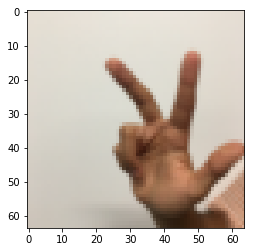

In [31]:
# 可视化

plt.imshow(train_set_x_orig[23])
print ("y = " + str(np.squeeze(train_set_y_orig[:, 23])))

In [32]:
# 数据处理

X_train_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
X_test_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

X_train = X_train_flatten/255. #标准化
X_test = X_test_flatten/255.

Y_train = np.eye(6)[train_set_y_orig.reshape(-1)].T # one-hot形式
Y_test = np.eye(6)[test_set_y_orig.reshape(-1)].T 

print('X_train shape:' + str(X_train.shape))
print('Y_train shape:' + str(Y_train.shape))
print('X_test shape:' + str(X_test.shape))
print('Y_test shape:' + str(Y_test.shape))

X_train shape:(12288, 1080)
Y_train shape:(6, 1080)
X_test shape:(12288, 120)
Y_test shape:(6, 120)


In [33]:
# 小批量随机

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    m = X.shape[1]            
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    num_complete_minibatches = math.floor(m/mini_batch_size) # 小批量数量
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0: # 剩余的小批量
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [34]:
# 参数初始化

def initialize_parameters():
    tf.set_random_seed(1) 
    
    W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [35]:
# 正向传播

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)                                           
    A1 = tf.nn.relu(Z1)                                             
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                             
    A2 = tf.nn.relu(Z2)                                            
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                               
    
    return Z3

def compute_cost(Z3, Y):

    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost

In [36]:
# 准确率

def predict(X, parameters):    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [37]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()  # 使重新运行时不覆盖tf的变量
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []                                        

    X = tf.placeholder(tf.float32, [n_x, None]) # 初始化
    Y = tf.placeholder(tf.float32, [n_y, None])
    parameters = initialize_parameters() 
    Z3 = forward_propagation(X, parameters) # 前向传播
    cost = compute_cost(Z3, Y) # 成本
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost) # Adam算法
    
    init = tf.global_variables_initializer() #变量初始化

    with tf.Session() as sess:
        
        sess.run(init) #运行变量初始化

        for epoch in range(num_epochs): 

            epoch_cost = 0. #每epoch一次后的成本值
            num_minibatches = int(m / minibatch_size) #小批量数目
            seed = seed + 1 
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed) #随机小批量

            for minibatch in minibatches: 
                
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("%i epoch 后的成本值 : %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print ("参数训练完毕")

        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("训练集准确度:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("测试集准确度:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

0 epoch 后的成本值 : 1.855702
100 epoch 后的成本值 : 1.016411
200 epoch 后的成本值 : 0.733188
300 epoch 后的成本值 : 0.572921
400 epoch 后的成本值 : 0.468836
500 epoch 后的成本值 : 0.381291
600 epoch 后的成本值 : 0.313962
700 epoch 后的成本值 : 0.254535
800 epoch 后的成本值 : 0.203957
900 epoch 后的成本值 : 0.166740
1000 epoch 后的成本值 : 0.142372
1100 epoch 后的成本值 : 0.107723
1200 epoch 后的成本值 : 0.085986
1300 epoch 后的成本值 : 0.060894
1400 epoch 后的成本值 : 0.051012


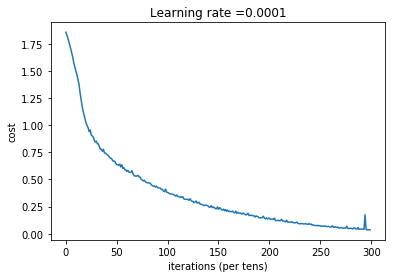

参数训练完毕
训练集准确度: 0.9990741
测试集准确度: 0.725


In [38]:
parameters = model(X_train, Y_train, X_test, Y_test)